# 메인퀘스트03 - 백승호

개요 : 이번 메인퀘스트에서는 기본적인 cnn구조에서부터 시작해 데이터 증강, 및 모델구조 변경 resnet사용 등 다양한 기법과 구조변경을 통해서 모델의 성능을 높여보는 실험을 통해 비교분석해보는 목표를 가지고 있다고 판단된다. 

목차 :
1. 폐렴진단기(베이스모델)을 구현하여 초기값 확인하기
2. 베이스 모델을 기반으로 데이터 증강 해보기
3. 베이스 모델을 기반으로 오버샘플링 해보기
4. 모델 구조 변경을 통해 베이스 모델과 성능 비교해보기(같은 주피터노트북 파일이 아닌 따로 저장)
5. ResNet-18을 통해 베이스 모델과 성능 비교해보기(같은 주피터노트북 파일이 아닌 따로 저장)

회고 : 모델을 하이퍼 파라미터를 조금 씩 만지고 모델의 성능을 높이기 위한 값을 찾아보고싶었으나 에폭을 하는데 많은 시간이 걸리기 때문에 많은 시행착오를 겪지 못한점이 아쉬운 부분으로 남습니다. 
그러나 분명 모델의 성능을 높이는 부분이 있었고, 오히려 모델의 성능이 떨어지는 조정도 있었던것 같습니다. 
예를 들면, 데이터 증강 기법은 테스트 결과가 원본에 비해 비약적인 정확도 향상을 보여주었으나,
모델 구조를 더 깊게 변경한 모델 구조 변경기법은 모델의 전체적인 파라미터가 원본데이터와 유사하거나 더 떨어지는 성능하락의 문제점을 확인하였습니다. 
그러나 그러한 문제점을 해결한 ResNet-18모델에 대한 학습을 통해서 베이스 모델에 비해 더 높은 성향향상에 성공하였습니다.
이번 메인퀘스트를 통해서 모델의 성능을 향상시키기란 쉽지 않지만, 데이터의 현실적인 부분을 잘캐치하고 키 값을 찾아내는 연습을 그리고 각 문제들에 대한 대응책과 접근법을 알게되어 매우 유익하였습니다. 

## 폐렴진단기(CNN 기반 베이스모델)

In [2]:
#라이브러리와 모듈을 불러오기

import os, re
import random, math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings(action='ignore')

In [3]:
# 데이터 로드할 때 빠르게 로드할 수 있도록하는 설정 변수
AUTOTUNE = tf.data.experimental.AUTOTUNE
# X-RAY 이미지 사이즈 변수
IMAGE_SIZE = [180, 180]

# 데이터 경로 변수
ROOT_PATH = os.path.join(os.getenv('HOME'), 'aiffel')
TRAIN_PATH = ROOT_PATH + '/chest_xray/data/train/*/*' # *은 모든 디렉토리와 파일을 의미합니다.
VAL_PATH = ROOT_PATH + '/chest_xray/data/val/*/*'
TEST_PATH = ROOT_PATH + '/chest_xray/data/test/*/*'

# 프로젝트를 진행할 때 아래 두 변수를 변경해보세요
BATCH_SIZE = 16
EPOCHS = 10

print(ROOT_PATH)

/aiffel/aiffel


In [4]:
train_filenames = tf.io.gfile.glob(TRAIN_PATH)
test_filenames = tf.io.gfile.glob(TEST_PATH)
val_filenames = tf.io.gfile.glob(VAL_PATH)

print(len(train_filenames))
print(len(test_filenames))
print(len(val_filenames))

5216
624
16


In [5]:
# train 데이터와 validation 데이터를 모두 filenames에 담습니다
filenames = tf.io.gfile.glob(TRAIN_PATH)
filenames.extend(tf.io.gfile.glob(VAL_PATH))

# 모아진 filenames를 8:2로 나눕니다
train_size = math.floor(len(filenames)*0.8)
random.seed(8)
random.shuffle(filenames)
train_filenames = filenames[:train_size]
val_filenames = filenames[train_size:]

print(len(train_filenames))
print(len(val_filenames))

4185
1047


In [6]:
print(f'Normal image path\n{filenames[0]}')
print(f'Pneumonia image path\n{filenames[2000]}')

Normal image path
/aiffel/aiffel/chest_xray/data/train/NORMAL/IM-0450-0001.jpeg
Pneumonia image path
/aiffel/aiffel/chest_xray/data/train/PNEUMONIA/person1345_bacteria_3422.jpeg


In [7]:
COUNT_NORMAL = len([filename for filename in train_filenames if "NORMAL" in filename])
print(f"Normal images count in training set: {COUNT_NORMAL}")


COUNT_PNEUMONIA = len([filename for filename in train_filenames if "PNEUMONIA" in filename])
print(f"Pneumonia images count in training set: {COUNT_PNEUMONIA}")

Normal images count in training set: 1070
Pneumonia images count in training set: 3115


In [8]:
train_list_ds = tf.data.Dataset.from_tensor_slices(train_filenames)
val_list_ds = tf.data.Dataset.from_tensor_slices(val_filenames)

In [9]:
TRAIN_IMG_COUNT = tf.data.experimental.cardinality(train_list_ds).numpy()
print(f"Training images count: {TRAIN_IMG_COUNT}")

VAL_IMG_COUNT = tf.data.experimental.cardinality(val_list_ds).numpy()
print(f"Validating images count: {VAL_IMG_COUNT}")

Training images count: 4185
Validating images count: 1047


In [10]:
# 파일 경로의 끝에서 두번째 부분을 확인하면 양성과 음성을 구분할 수 있습니다
def get_label(file_path):
    parts = tf.strings.split(file_path, os.path.sep)
    return parts[-2] == "PNEUMONIA"   # 폐렴이면 양성(True), 노말이면 음성(False)

In [11]:
# 이미지를 알맞은 형식으로 바꿉니다.
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3) # 이미지를 uint8 tensor로 수정
    img = tf.image.convert_image_dtype(img, tf.float32) # float32 타입으로 수정
    img = tf.image.resize(img, IMAGE_SIZE) # 이미지 사이즈를 IMAGE_SIZE로 수정
    return img

# 이미지 파일의 경로를 입력하면 이미지와 라벨을 읽어옵니다.
def process_path(file_path):
    label = get_label(file_path) # 라벨 검출
    img = tf.io.read_file(file_path) # 이미지 읽기
    img = decode_img(img) # 이미지를 알맞은 형식으로 수정
    return img, label

In [12]:
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [13]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  False


In [14]:
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)
TEST_IMAGE_COUNT = tf.data.experimental.cardinality(test_list_ds).numpy()
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

print(TEST_IMAGE_COUNT)

624


In [15]:
def prepare_for_training(ds, shuffle_buffer_size=1000):
    ds = ds.shuffle(buffer_size=shuffle_buffer_size)
    ds = ds.repeat()
    ds = ds.batch(BATCH_SIZE)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

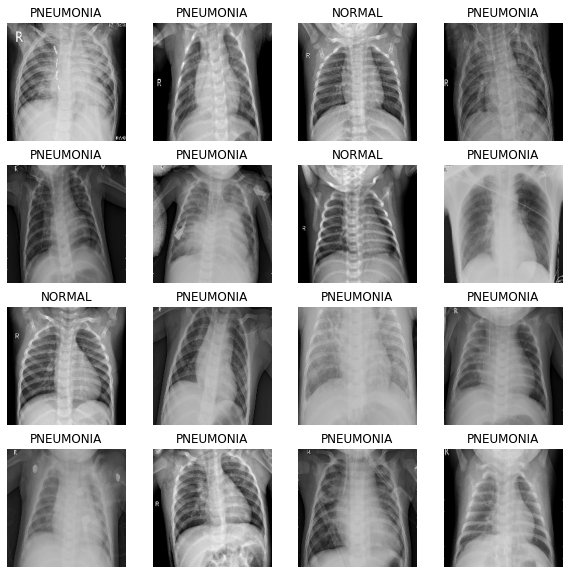

In [16]:
# 이미지 배치를 입력하면 여러장의 이미지를 보여줍니다.
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(BATCH_SIZE):
        ax = plt.subplot(4,math.ceil(BATCH_SIZE/4),n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")


image_batch, label_batch = next(iter(train_ds))
show_batch(image_batch.numpy(), label_batch.numpy())

In [17]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ])
    
    return block

In [18]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [19]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [20]:
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_PNEUMONIA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for NORMAL: {:.2f}'.format(weight_for_0))
print('Weight for PNEUMONIA: {:.2f}'.format(weight_for_1))

Weight for NORMAL: 1.96
Weight for PNEUMONIA: 0.67


In [21]:
with tf.device('/GPU:0'):
    model = build_model()

    METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=METRICS
    )

In [22]:
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

Epoch 1/10
261/261 [==============================] - 68s 208ms/step - loss: 0.4033 - accuracy: 0.8142 - precision: 0.9548 - recall: 0.7877 - val_loss: 0.7164 - val_accuracy: 0.7337 - val_precision: 0.7337 - val_recall: 1.0000
Epoch 2/10
261/261 [==============================] - 53s 204ms/step - loss: 0.2419 - accuracy: 0.9035 - precision: 0.9718 - recall: 0.8965 - val_loss: 1.2733 - val_accuracy: 0.7346 - val_precision: 0.7346 - val_recall: 1.0000
Epoch 3/10
261/261 [==============================] - 53s 205ms/step - loss: 0.2101 - accuracy: 0.9167 - precision: 0.9729 - recall: 0.9134 - val_loss: 0.5234 - val_accuracy: 0.7923 - val_precision: 0.7794 - val_recall: 1.0000
Epoch 4/10
261/261 [==============================] - 54s 207ms/step - loss: 0.1697 - accuracy: 0.9341 - precision: 0.9810 - recall: 0.9296 - val_loss: 0.1464 - val_accuracy: 0.9394 - val_precision: 0.9929 - val_recall: 0.9238
Epoch 5/10
261/261 [==============================] - 55s 210ms/step - loss: 0.1892 - accura

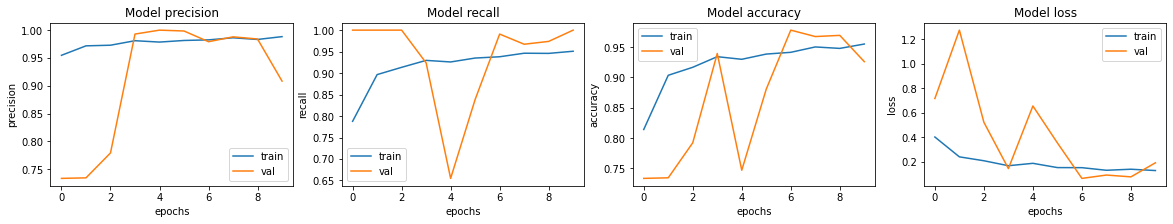

In [23]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [25]:
loss, accuracy, precision, recall = model.evaluate(test_ds)
print(f'Loss: {loss},\nAccuracy: {accuracy},\nPrecision: {precision},\nRecall: {recall}')

39/39 [==============================] - 5s 121ms/step - loss: 1.2473 - accuracy: 0.6715 - precision: 0.6555 - recall: 1.0000
Loss: 1.247291088104248,
Accuracy: 0.6714743375778198,
Precision: 0.6554622054100037,
Recall: 1.0


### 결과 분석 : 

CNN 기반 베이스 모델
Loss (1.2473):
손실 값이 비교적 높은 편입니다. 이는 모델이 예측을 확신하지 못하고 잘못된 예측을 많이 했음을 나타낼 수 있습니다.


Accuracy (67.15%):
정확도가 67%로, 모델이 전체적으로 약 3분의 2 정도만 올바르게 예측했음을 의미합니다.
하지만 불균형 데이터셋에서 정확도는 신뢰할 수 있는 지표가 아닐 수 있습니다.


Precision (65.55%):
Precision은 모델이 폐렴(PNEUMONIA)으로 예측한 사례 중 실제로 폐렴인 비율입니다.
약 65%로, 모델이 폐렴으로 예측한 케이스 중 35%는 잘못된 예측임을 나타냅니다.
Precision이 낮은 이유는 데이터 불균형, 과적합, 또는 적절하지 않은 학습률 때문일 수 있습니다.


Recall (100%):
Recall은 실제 폐렴 중에서 모델이 올바르게 예측한 비율입니다.
100%라는 값은 모델이 폐렴 사례를 놓치지 않았음을 나타냅니다.
그러나, Precision과 Loss 결과를 보면, 모델이 대부분의 데이터를 폐렴으로 잘못 분류하여 Recall이 높게 나타난 것으로 보입니다.

## 데이터 Augmentation 기법 활용

Epoch 1/10
261/261 [==============================] - 63s 208ms/step - loss: 0.2624 - accuracy: 0.8918 - precision: 0.9669 - recall: 0.8848 - val_loss: 0.1904 - val_accuracy: 0.9250 - val_precision: 0.9914 - val_recall: 0.9056
Epoch 2/10
261/261 [==============================] - 54s 209ms/step - loss: 0.1977 - accuracy: 0.9227 - precision: 0.9754 - recall: 0.9193 - val_loss: 0.1170 - val_accuracy: 0.9529 - val_precision: 0.9863 - val_recall: 0.9488
Epoch 3/10
261/261 [==============================] - 54s 208ms/step - loss: 0.1885 - accuracy: 0.9217 - precision: 0.9777 - recall: 0.9157 - val_loss: 0.6734 - val_accuracy: 0.7740 - val_precision: 1.0000 - val_recall: 0.6912
Epoch 4/10
261/261 [==============================] - 55s 209ms/step - loss: 0.1858 - accuracy: 0.9298 - precision: 0.9802 - recall: 0.9244 - val_loss: 0.1047 - val_accuracy: 0.9625 - val_precision: 0.9892 - val_recall: 0.9593
Epoch 5/10
261/261 [==============================] - 55s 213ms/step - loss: 0.1631 - accura

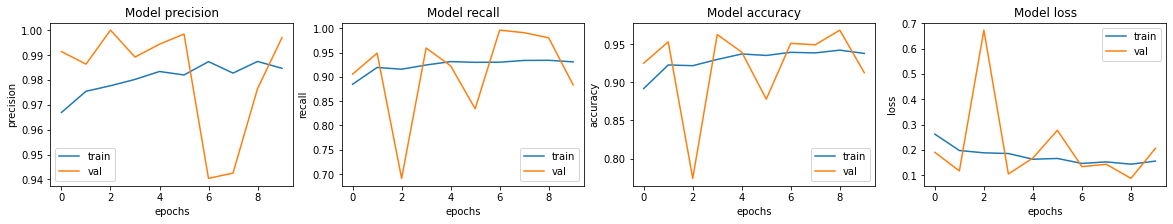

In [26]:
# 데이터 증강 함수
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # 좌우 뒤집기
    image = tf.image.random_flip_up_down(image)    # 상하 뒤집기
    image = tf.image.random_brightness(image, max_delta=0.2)  # 밝기 조정
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # 대비 조정
    return image, label

# 학습 데이터 파이프라인에 증강 적용
train_ds = train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 기존 전처리
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)  # 데이터 증강 추가
train_ds = prepare_for_training(train_ds)

# 검증 데이터셋 (증강 없이 유지)
val_ds = val_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = prepare_for_training(val_ds)

# 모델 재훈련
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds,
        steps_per_epoch=TRAIN_IMG_COUNT // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )

# 결과 시각화
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])


In [27]:
# 테스트 데이터셋 준비
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)  # 테스트 데이터 파일 경로 읽기
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 전처리 함수 매핑
test_ds = test_ds.batch(BATCH_SIZE)  # 배치 구성

# 테스트 데이터 평가
with tf.device('/GPU:0'):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


39/39 [==============================] - 5s 119ms/step - loss: 0.4234 - accuracy: 0.8558 - precision: 0.8676 - recall: 0.9077
Loss: 0.4233865439891815
Accuracy: 0.8557692170143127
Precision: 0.8676470518112183
Recall: 0.9076923131942749


### 결과분석 : 

데이터 Augmentation 기법으로 좌우반전,상하반전, 밝기와 대비를 조정하였다. 그로인한 테스트 결과는 정확도가 0.67-> 0.85까지 올라가는 양상을 보여주었으며 recall값은 1.0->0.9로 떨어지는 양상을 보여준다. 그러나 현재 사용하고 있는 데이터셋의 가장큰 문제점인 데이터 불균형 문제를 바로 잡기 전에는 이러한 결과값을 신뢰하기는 어려워보인다. 

## 오버샘플링을 통한 데이터 불균형 해소 결과비교

In [28]:
# 정상 데이터만 필터링하여 오버샘플링
normal_filenames = [filename for filename in train_filenames if "NORMAL" in filename]
pneumonia_filenames = [filename for filename in train_filenames if "PNEUMONIA" in filename]

# 정상 데이터를 반복하여 폐렴 데이터와 균형 맞추기
oversampled_normal_filenames = normal_filenames * (len(pneumonia_filenames) // len(normal_filenames)) + normal_filenames[:len(pneumonia_filenames) % len(normal_filenames)]

# 균형 잡힌 데이터셋 생성
balanced_filenames = pneumonia_filenames + oversampled_normal_filenames
random.shuffle(balanced_filenames)

# 균형 잡힌 학습 데이터셋 생성
balanced_train_list_ds = tf.data.Dataset.from_tensor_slices(balanced_filenames)
balanced_train_ds = balanced_train_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
balanced_train_ds = balanced_train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)  # 증강 추가
balanced_train_ds = prepare_for_training(balanced_train_ds)

# 데이터 분포 확인
balanced_count_normal = len([filename for filename in balanced_filenames if "NORMAL" in filename])
balanced_count_pneumonia = len([filename for filename in balanced_filenames if "PNEUMONIA" in filename])
print(f"Balanced Normal images: {balanced_count_normal}")
print(f"Balanced Pneumonia images: {balanced_count_pneumonia}")


Balanced Normal images: 3115
Balanced Pneumonia images: 3115


In [29]:
with tf.device('/GPU:0'):
    history = model.fit(
        balanced_train_ds,  # 오버샘플링된 데이터셋 사용
        steps_per_epoch=len(balanced_filenames) // BATCH_SIZE,
        epochs=EPOCHS,
        validation_data=val_ds,
        validation_steps=VAL_IMG_COUNT // BATCH_SIZE,
        class_weight=class_weight,
    )


Epoch 1/10
389/389 [==============================] - 103s 238ms/step - loss: 0.2324 - accuracy: 0.9269 - precision: 0.9666 - recall: 0.8844 - val_loss: 0.1112 - val_accuracy: 0.9548 - val_precision: 0.9917 - val_recall: 0.9462
Epoch 2/10
389/389 [==============================] - 91s 234ms/step - loss: 0.1726 - accuracy: 0.9359 - precision: 0.9748 - recall: 0.8949 - val_loss: 0.2282 - val_accuracy: 0.9010 - val_precision: 1.0000 - val_recall: 0.8647
Epoch 3/10
389/389 [==============================] - 91s 234ms/step - loss: 0.1504 - accuracy: 0.9422 - precision: 0.9788 - recall: 0.9038 - val_loss: 0.0817 - val_accuracy: 0.9654 - val_precision: 0.9919 - val_recall: 0.9607
Epoch 4/10
389/389 [==============================] - 91s 235ms/step - loss: 0.1370 - accuracy: 0.9475 - precision: 0.9820 - recall: 0.9117 - val_loss: 0.1073 - val_accuracy: 0.9577 - val_precision: 0.9511 - val_recall: 0.9935
Epoch 5/10
389/389 [==============================] - 93s 239ms/step - loss: 0.1453 - accur

In [31]:
# 테스트 데이터셋 준비
test_list_ds = tf.data.Dataset.list_files(TEST_PATH)  # 테스트 데이터 파일 경로 읽기
test_ds = test_list_ds.map(process_path, num_parallel_calls=AUTOTUNE)  # 전처리 함수 적용
test_ds = test_ds.batch(BATCH_SIZE)  # 배치 구성

# 테스트 데이터 평가
with tf.device('/GPU:0'):
    loss, accuracy, precision, recall = model.evaluate(test_ds)
    print(f"Loss: {loss}")
    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")


39/39 [==============================] - 5s 120ms/step - loss: 0.8073 - accuracy: 0.8093 - precision: 0.7694 - recall: 0.9923
Loss: 0.8073369860649109
Accuracy: 0.8092948794364929
Precision: 0.7693836688995361
Recall: 0.9923076629638672


### 결과 분석 : 

데이터 오버샘플링을 통해 데이터의 비율을 약 1:1까까이 맞추어보았으나 오히려 정확도가 떨어지는 모습을 볼 수 있었다. 
오버샘플링을 통해 전체적인 데이터 양이 많아진 탓인지 에폭시간도 약 1.8가량 늘어났다. 